## 라이브러리 설치

In [ ]:
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.2 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

In [ ]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.utils import to_categorical


# vagetable image dataset 다운로드

In [ ]:
# 구글 코랩에서 데이터셋 다운로드 및 준비
from google.colab import drive
drive.mount('/content/drive')

# # kaggle vagitable image 데이터셋 다운로드
!unzip '/content/drive/MyDrive/archive.zip' -d /content/dataset

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/dataset/Vegetable Images/train/Radish/0001.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0002.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0003.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0004.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0005.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0006.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0007.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0008.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0009.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0010.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0011.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0012.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0013.jpg  
  inflating: /content/dataset/Vegetable I

In [ ]:
# 학습(train), 테스트(test), 검증(validation) 데이터셋 경로 지정
train_dir = 'dataset/Vegetable Images/train'
test_dir = 'dataset/Vegetable Images/test'
val_dir = 'dataset/Vegetable Images/validation'

# EDA(Exploratory Data Analysis)

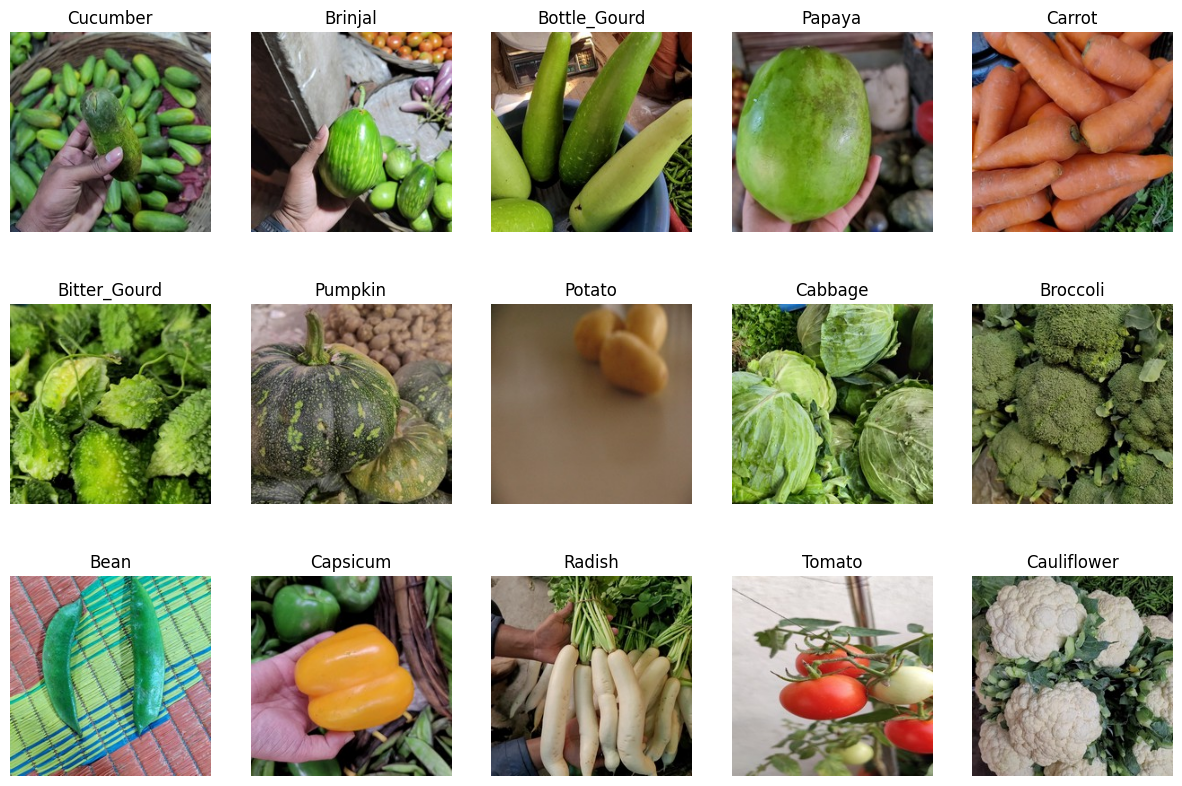

In [ ]:
# 데이터셋 이미지 시각화
image_dimensions = []

# 클래스 리스트 가져오기
clsses = os.listdir(train_dir)

plt.figure(figsize=(15, 10))

# 각 클래스와 이미지 표츌
for i, class_name in enumerate(clsses):
  class_dir = os.path.join(train_dir, class_name)
  images = os.listdir(class_dir)

  # 각 클래스에서 첫 번째 이미지 가져오기
  image_path = os.path.join(class_dir, images[0])
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # opencv의 brg색상을 cvtCOLOR를 활용하여 rgb로 변환

  # 이미지 형태 저장
  height, width, channels = image.shape
  image_dimensions.append((height, width, channels))

  # 이미지 시각화
  plt.subplot(3, 5, i+1)
  plt.imshow(image)
  plt.title(class_name)
  plt.axis('off')

# plt.show()

In [ ]:
# 이미지 크기 확인
df = pd.DataFrame(image_dimensions, columns=['Height', 'Width', 'Channels'])
df.describe().loc[['min', 'mean', 'max']]

,Height,Width,Channels
min,224.0,224.0,3.0
mean,224.0,224.0,3.0
max,224.0,224.0,3.0


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

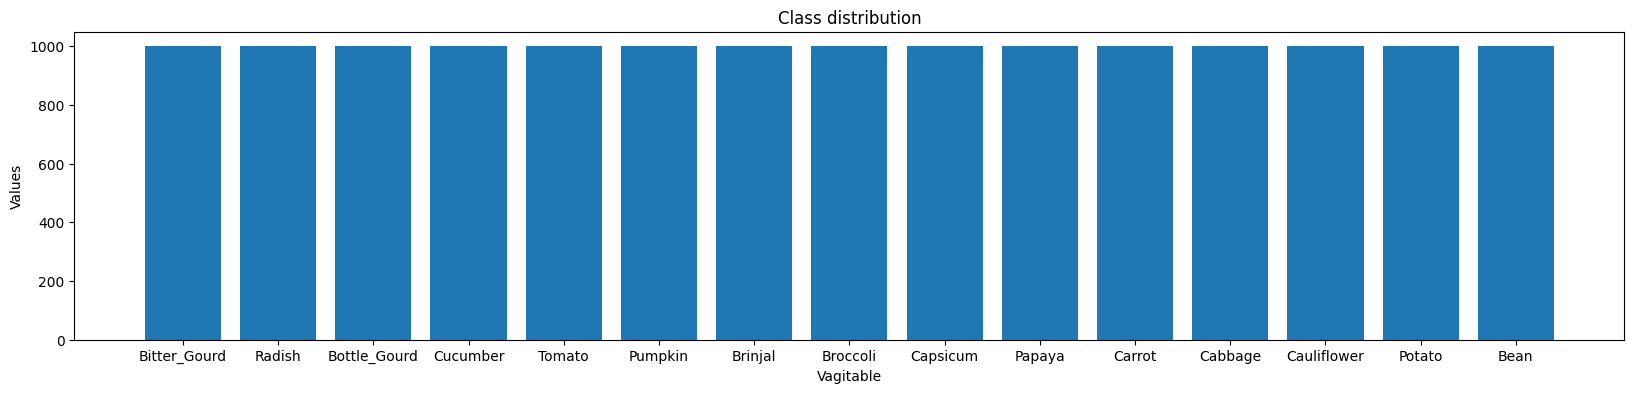

In [ ]:
# 클래스별 데이터셋 분포 확인
# 디렉토리 초기화
count_dict = {}

# 클래스명, 파일 갯수 저장
for root, dirs, files in os.walk(train_dir):
  clase = os.path.basename(root)
  count_dict[clase] = len(files)

lables = list(count_dict.keys())[1:] # 슬라이싱으로 클래스 첫 번째 항목부터 추출
values = list(count_dict.values())[1:]

plt.figure(figsize=(20, 4))
plt.bar(lables, values)
plt.title('Class distribution')
plt.xlabel('Vagitable')
plt.ylabel('Values')
plt

## 학습 그래프 시각화

In [ ]:
# 학습 그래프 시각화 정의
def plot_learning_curves(history):
  plt.figure(figsize=(12, 4))

  # Loss plot
  plt.subplot(1, 2, 1)
  plt.plot(history['loss'], label='Training Loss')
  plt.plot(history['val_loss'], label='Validation Loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # Accuracy plot
  plt.subplot(1, 2, 2)
  plt.plot(history['accuracy'], label='Training Accuracy')
  plt.plot(history['val_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.ylim(0, 1)  # Set the y-axis range for accuracy from 0 to 1

# VGG16

## VGG16 기본 설정

In [ ]:
# 전역 변수
input_shape = (224, 224, 3)
num_classes = 15

In [ ]:
# 학습 데이터 정규화
train_datagen = ImageDataGenerator(
    rescale = 1./255, # 픽셀 정규화
)

# 테스트, 검증 데이터 정규화
test_val_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [ ]:
# VGG16 모델 로드
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# 레이어 동결
for layer in base_model.layers:
  layer.trainable = False

# 모델 구성
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(train_generator, epochs=10, batch_size=batch_size,
                    validation_data=val_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 9972s 169s/step - accuracy: 0.0582 - loss: 2.8022 - val_accuracy: 0.2357 - val_loss: 2.5463
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 9983s 170s/step - accuracy: 0.3245 - loss: 2.4888 - val_accuracy: 0.5730 - val_loss: 2.3092
Epoch 3/10
24/59 ━━━━━━━━━━━━━━━━━━━━ 1:22:28 141s/step - accuracy: 0.5774 - loss: 2.2958

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f"✅ Test loss: {loss}")
print(f"✅ Test accuracy: {accuracy}")

In [ ]:
# 그래프 시각화
history_df = pd.DataFrame(history.history)
plot_learning_curves(history_df)

In [ ]:
# 학습된 모델 저장
model_save_path = os.path.join('/content/drive/My Drive/models', 'model_VGG16.keras')
model.save(model_save_path)

In [ ]:
# 드라이브에 저장된 모델 불러오기
model_load_path = os.path.join('/content/drive/My Drive/models', 'model_VGG16.keras')
loaded_model = tf.keras.models.load_model(model_load_path)

# 불러온 모델 확인
loaded_model.summary()

# 불러온 모델 평가
loss, accuracy = loaded_model.evaluate(test_generator)
print(f"✅ Loaded model Test loss: {loss}")
print(f"✅ Loaded model Test accuracy: {accuracy}")

In [ ]:
# 데이터 예측
true_classes = test_generator.classes
predictions = loaded_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
test_labels=test_generator.class_indices.keys()

In [ ]:
# 리포트 작성
report = classification_report(true_classes, predicted_classes, target_names=test_labels)
print(report)

In [ ]:
# 예측결과 시각화 매트릭스
plt.figure(figsize=(12,12))
cm=confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d',cmap="Blues", xticklabels=test_labels,yticklabels=test_labels)
plt.title("Confusion Matrix")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

## VGG16 데이터 증강

In [ ]:
# VGG16 파라미터
image_size = (224, 224)
batch_size = 32

# 학습 데이터 증강
train_datagen = ImageDataGenerator(
    rescale = 1./255, # 픽셀 정규화
    rotation_range=20, # 1~20 무작위 회전
    width_shift_range=0.2, # 수평 방향 이동
    height_shift_range=0.2, # 수직 방향 이동
    shear_range=0.2, # 전단 변환
    zoom_range=0.2, # 확대, 축소
    horizontal_flip=True, # 뒤집기
    fill_mode='nearest' # 이미지 변형 중 빈 공간 채우기
)

# 테스트, 검증 데이터 정규화
test_val_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [ ]:

# VGG16 모델 로드
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# 레이어 동결
for layer in base_model.layers:
  layer.trainable = False

# 모델 구성
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# 콜백
early_stoping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# 학습률 조정
resuce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 모델 학습
history = model.fit(train_generator, epochs=10, batch_size=batch_size,
                    validation_data=val_generator, callbacks=[early_stoping, resuce_lr])

In [ ]:
model_save_path = os.path.join('/content/drive/My Drive/models', 'model_VGG16_gen_new.keras')
model.save(model_save_path)

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f"✅ Test loss: {loss}")
print(f"✅ Test accuracy: {accuracy}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 158ms/step - accuracy: 0.9764 - loss: 0.0711
✅ Test loss: 0.071581169962883
✅ Test accuracy: 0.9766666889190674


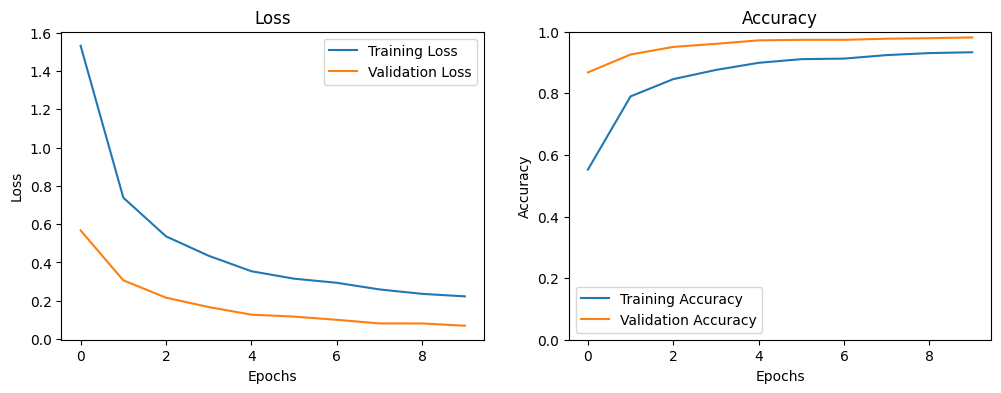

In [ ]:
history_df = pd.DataFrame(history.history)
plot_learning_curves(history_df)

## VGG16 최적의 하이퍼파라미터 탐색

In [ ]:
# 1. 모델 빌딩 함수
def build_model(hp):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    # Dense 레이어의 유닛 수 탐색: 128, 256, 512 중 선택
    dense_units = hp.Choice('dense_units', values=[128, 256, 512])

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(dense_units, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    # 학습률 하이퍼파라미터: 로그 스케일로 탐색
    lr = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')

    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
# 2. 배치 사이즈 튜닝을 위한 커스텀 Tuner 클래스 정의
class MyTuner(kt.tuners.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        # 배치 사이즈 하이퍼파라미터 추가: 16, 32, 64 중 선택
        hp = trial.hyperparameters
        batch_size = hp.Choice('batch_size', values=[16, 32, 64])
        kwargs['batch_size'] = batch_size
        return super(MyTuner, self).run_trial(trial, *args, **kwargs)

In [ ]:
# 3. Tuner 생성
tuner = MyTuner(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # 탐색할 하이퍼파라미터 조합 수
    executions_per_trial=1,
    directory='my_dir',
    project_name='VGG16_tuning'
)

# 4. 하이퍼파라미터 탐색 실행
tuner.search(train_generator, epochs=5, validation_data=val_generator)
# 요약 결과
tuner.results_summary()

# 5. 최적의 하이퍼파라미터 추출
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_lr = best_hps.get('learning_rate')
best_bs = best_hps.get('batch_size')
best_dense_units = best_hps.get('dense_units')

print("✅ Best learning rate:", best_lr)
print("✅ Best batch size:", best_bs)
print("✅ Best dense units:", best_dense_units)

Trial 10 Complete [00h 18m 57s]
val_accuracy: 0.8533333539962769

Best val_accuracy So Far: 0.9266666769981384
Total elapsed time: 03h 06m 04s
Results summary
Results in my_dir/VGG16_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 06 summary
Hyperparameters:
dense_units: 256
learning_rate: 0.00021916387613350112
batch_size: 64
Score: 0.9266666769981384

Trial 01 summary
Hyperparameters:
dense_units: 256
learning_rate: 0.00016991743327040125
batch_size: 64
Score: 0.9196666479110718

Trial 04 summary
Hyperparameters:
dense_units: 256
learning_rate: 0.0001620301758122103
batch_size: 32
Score: 0.9096666574478149

Trial 03 summary
Hyperparameters:
dense_units: 128
learning_rate: 0.00021627554608080973
batch_size: 64
Score: 0.906000018119812

Trial 02 summary
Hyperparameters:
dense_units: 256
learning_rate: 9.320391450193125e-05
batch_size: 32
Score: 0.8743333220481873

Trial 09 summary
Hyperparameters:
dense_units: 128
learning_rate: 9.550630393190334e-0

In [ ]:
# 6. 최적의 하이퍼파라미터로 모델 생성 및 최종 학습
# model = build_model(best_hps)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# 학습률 하이퍼파라미터: 로그 스케일로 탐색

model.compile(optimizer=Adam(learning_rate=1.5114998050474302e-05),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

 # 최종 학습을 위한 콜백 정의
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1)
checkpoint_path = os.path.join('/content/drive/My Drive/models', 'VGG16_find_hyper.keras')
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1) # 가중치 저장

model.fit(train_generator, epochs=20, batch_size=16,
          validation_data=val_generator, callbacks=[early_stopping, reduce_lr, checkpoint])

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.0693 - loss: 2.8930 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.16333, saving model to best_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 11366s 24s/step - accuracy: 0.0693 - loss: 2.8928 - val_accuracy: 0.1633 - val_loss: 2.6368 - learning_rate: 1.5115e-05
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.1053 - loss: 2.7007 

In [ ]:
# 파인튜닝
for layer in build_model.base_model.layers:
    layer.trainable = True

# 모델 재컴파일
model.compile(optimizer=Adam(learning_rate=best_lr/10), # 학습률 낮춰서 파인튜닝
          loss='categorical_crossentropy',
          metrics=['accuracy'])

history = model.fit(train_generator, epochs=20, batch_size=best_bs,
                    validation_data=val_generator, callbacks=[early_stopping, reduce_lr, checkpoint])

In [ ]:
model_save_path = os.path.join('/content/drive/My Drive/models', 'model_VGG16_tunning.keras')
model.save(model_save_path)

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f"✅ Test loss: {loss}")
print(f"✅ Test accuracy: {accuracy}")

In [ ]:
history_df = pd.DataFrame(history.history)
plot_learning_curves(history_df)

In [ ]:
# prompt: 드라이브에 저장된 모델 불러오기
model_load_path = os.path.join('/content/drive/My Drive/models', 'model_VGG16.keras')
loaded_model = tf.keras.models.load_model(model_load_path)

# 불러온 모델 확인
loaded_model.summary()

# 불러온 모델 평가
loss, accuracy = loaded_model.evaluate(test_generator)
print(f"✅ Loaded model Test loss: {loss}")
print(f"✅ Loaded model Test accuracy: {accuracy}")

In [ ]:
# 데이터 예측
# Get the true classes (ground truth) from the test generator
true_classes = test_generator.classes

# Predict probabilities for each class using the model
predictions = loaded_model.predict(test_generator)

# Convert probabilities to predicted class indices (select the class with the highest probability)
predicted_classes = np.argmax(predictions, axis=1)

test_labels=test_generator.class_indices.keys()

In [ ]:
# Generate the classification report
# target_names assigns human-readable class names from the test generator
report = classification_report(true_classes, predicted_classes, target_names=test_labels)
print(report)

In [ ]:
plt.figure(figsize=(12,12))
cm=confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d',cmap="Blues", xticklabels=test_labels,yticklabels=test_labels)
plt.title("Confusion Matrix")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

## VGG16 파인 튜닝

In [ ]:
# prompt: 드라이브에 저장된 모델 불러오기
model_load_path = os.path.join('/content/drive/My Drive/models', 'VGG16_find_hyper.keras')
model = tf.keras.models.load_model(model_load_path)

# 불러온 모델 확인
model.summary()

# # 불러온 모델 평가
# loss, accuracy = loaded_model.evaluate(test_generator)
# print(f"✅ Loaded model Test loss: {loss}")
# print(f"✅ Loaded model Test accuracy: {accuracy}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,120,239 (57.68 MB)

 Trainable params: 135,183 (528.06 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 270,368 (1.03 MB)

In [ ]:
!pip install pymysql

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 2.5 MB/s eta 0:00:00


In [ ]:
import datetime
import pymysql  # 또는 psycopg2 (PostgreSQL 사용시)

# 최적 하이퍼파라미터 설정
best_lr = 0.00021916387613350112
best_bs = 64

# 모든 레이어 학습 가능 설정
for layer in model.layers:
    layer.trainable = True

# Callback 설정
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=best_lr / 10),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 데이터베이스 연결 설정
conn = pymysql.connect(host='my host', port=21739, user='user', password='my password', db='dbname')
cursor = conn.cursor()

# 테이블 생성 (최초 1회만 실행)
cursor.execute("""
CREATE TABLE IF NOT EXISTS VGG16_fullfinetunning_training_new_log (
    id INT AUTO_INCREMENT PRIMARY KEY,
    start_time DATETIME,
    end_time DATETIME,
    epoch INT,
    loss FLOAT,
    accuracy FLOAT,
    val_loss FLOAT,
    val_accuracy FLOAT
);
""")
conn.commit()

# 학습 시작
for epoch in range(20):
    print(f"Epoch {epoch+1}/20")

    epoch_start_time = datetime.datetime.now()

    history = model.fit(train_generator,
                        epochs=1,
                        batch_size=best_bs,
                        validation_data=val_generator,
                        callbacks=[early_stopping, reduce_lr, checkpoint])

    epoch_end_time = datetime.datetime.now()

    # 에포크 결과
    loss = history.history['loss'][-1]
    accuracy = history.history['accuracy'][-1]
    val_loss = history.history['val_loss'][-1]
    val_accuracy = history.history['val_accuracy'][-1]

    # DB에 기록 저장
    cursor.execute("""
        INSERT INTO VGG16_fullfinetunning_training_new_log (start_time, end_time, epoch, loss, accuracy, val_loss, val_accuracy)
        VALUES (%s, %s, %s, %s, %s, %s, %s);
    """, (epoch_start_time, epoch_end_time, epoch + 1, loss, accuracy, val_loss, val_accuracy))

    conn.commit()

# DB 연결 종료
cursor.close()
conn.close()


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.9549 - loss: 0.1635
Epoch 1: val_accuracy improved from -inf to 0.98333, saving model to best_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 259s 512ms/step - accuracy: 0.9549 - loss: 0.1635 - val_accuracy: 0.9833 - val_loss: 0.0691 - learning_rate: 2.1916e-05
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9566 - loss: 0.1598
Epoch 1: val_accuracy improved from 0.98333 to 0.98367, saving model to best_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 226s 481ms/step - accuracy: 0.9566 - loss: 0.1598 - val_accuracy: 0.9837 - val_loss: 0.0688 - learning_rate: 2.1916e-05
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9574 - loss: 0.1594
Epoch 1: val_accuracy did not improve from 0.98367
469/469 ━━━━━━━━━━━━━━━━━━━━ 231s 493ms/step - accuracy: 0.9574 - loss: 0.1594 - val_accuracy: 0.9827 - val_loss: 0.0683 - learning_rate: 2.1916e-05
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.9595 -

In [ ]:
# 최종 모델 저장
model_save_path = os.path.join('/content/drive/My Drive/models', 'model_VGG16_full_fine_tuning.keras')
model.save(model_save_path)

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f"✅ Test loss: {loss}")
print(f"✅ Test accuracy: {accuracy}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 181ms/step - accuracy: 0.9879 - loss: 0.0453
✅ Test loss: 0.06083434075117111
✅ Test accuracy: 0.981333315372467


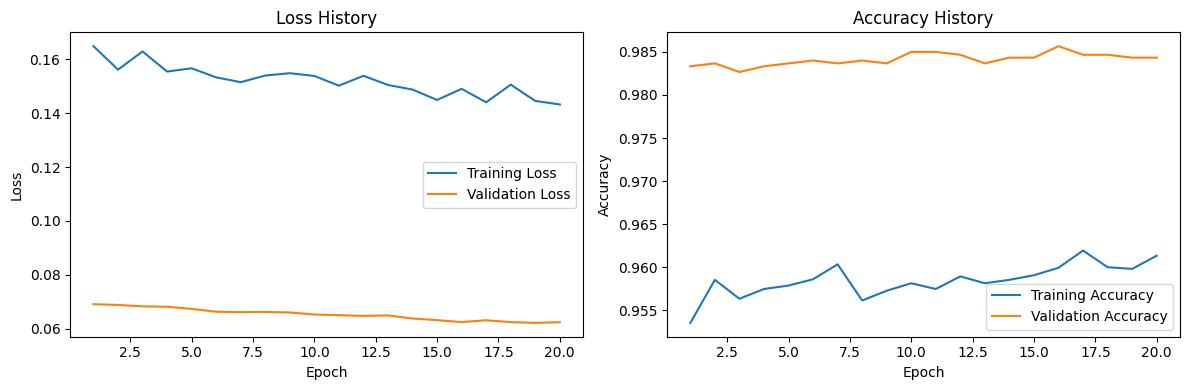

In [ ]:
# prompt: 위에서 DB에 저장한 로그를 불러와서 히스토리 그래프를 시각화하는 코드를 작성해줘

import pandas as pd
import matplotlib.pyplot as plt
import pymysql
# DB에서 로그 데이터 가져오기
conn = pymysql.connect(host='host', port=21739, user='user', password='password', db='defaultdb')
cursor = conn.cursor()

cursor.execute("SELECT epoch, loss, accuracy, val_loss, val_accuracy FROM VGG16_fullfinetunning_training_new_log")
data = cursor.fetchall()

cursor.close()
conn.close()

# DataFrame으로 변환
df = pd.DataFrame(data, columns=['epoch', 'loss', 'accuracy', 'val_loss', 'val_accuracy'])

# 히스토리 그래프 시각화
plt.figure(figsize=(12, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['loss'], label='Training Loss')
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['accuracy'], label='Training Accuracy')
plt.plot(df['epoch'], df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# prompt: 저장된 full finetunning 모델을 불러오는 코드를 작성해줘

# 모델 로드 경로 설정
model_load_path = os.path.join('/content/drive/My Drive/models', 'model_VGG16_full_fine_tuning.keras')

# 모델 로드
loaded_model = tf.keras.models.load_model(model_load_path)

# 로드된 모델 확인
loaded_model.summary()

# # 로드된 모델 평가 (선택 사항)
# loss, accuracy = loaded_model.evaluate(test_generator)
# print(f"✅ Loaded model Test loss: {loss}")
# print(f"✅ Loaded model Test accuracy: {accuracy}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,120,239 (57.68 MB)

 Trainable params: 135,183 (528.06 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 270,368 (1.03 MB)

In [ ]:
# 데이터 예측
# Get the true classes (ground truth) from the test generator
true_classes = test_generator.classes

# Predict probabilities for each class using the model
predictions = loaded_model.predict(test_generator)

# Convert probabilities to predicted class indices (select the class with the highest probability)
predicted_classes = np.argmax(predictions, axis=1)

test_labels=test_generator.class_indices.keys()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 34s 241ms/step


In [ ]:
# Generate the classification report
# target_names assigns human-readable class names from the test generator
report = classification_report(true_classes, predicted_classes, target_names=test_labels)
print(report)

              precision    recall  f1-score   support

        Bean       0.99      0.99      0.99       200
Bitter_Gourd       0.99      0.99      0.99       200
Bottle_Gourd       0.98      0.98      0.98       200
     Brinjal       0.95      0.99      0.97       200
    Broccoli       1.00      0.99      0.99       200
     Cabbage       0.99      0.98      0.99       200
    Capsicum       0.99      0.99      0.99       200
      Carrot       0.97      0.98      0.98       200
 Cauliflower       0.96      0.99      0.98       200
    Cucumber       0.98      0.95      0.97       200
      Papaya       0.97      0.96      0.97       200
      Potato       0.99      0.98      0.99       200
     Pumpkin       0.98      0.98      0.98       200
      Radish       0.99      0.96      0.98       200
      Tomato       0.99      0.98      0.98       200

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98   

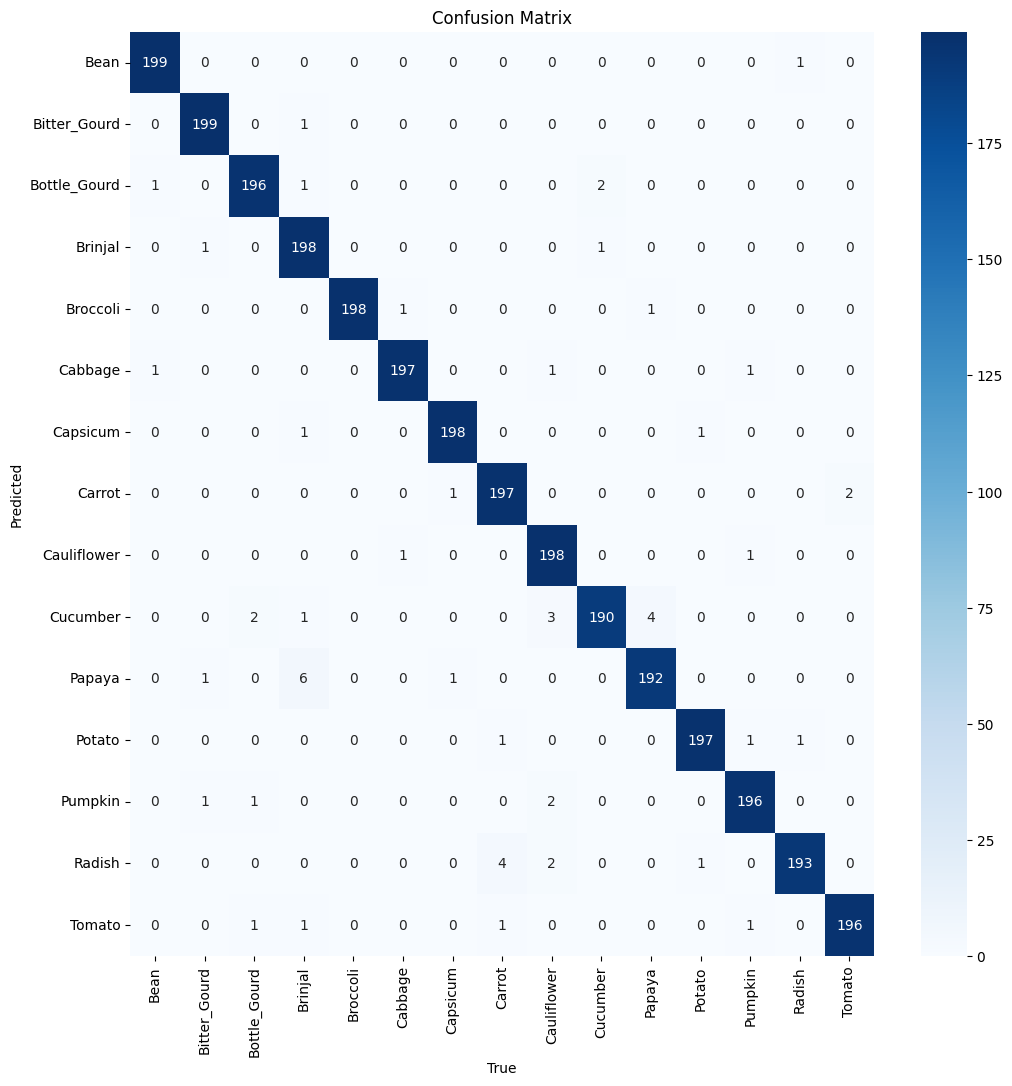

In [ ]:
plt.figure(figsize=(12,12))
cm=confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d',cmap="Blues", xticklabels=test_labels,yticklabels=test_labels)
plt.title("Confusion Matrix")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

# MobileNetV2

In [ ]:
# # MobileNetV2 파라미터
image_size = (224, 224)
batch_size = 32

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [ ]:
# 학습 데이터 증강
train_datagen = ImageDataGenerator(
    rescale=1./255, # 픽셀 정규화
    rotation_range=20, # 1~20 무작위 회전
    width_shift_range=0.2, # 수평 방향 이동
    height_shift_range=0.2, # 수직 방향 이동
    shear_range=0.2, # 전단 변환
    zoom_range=0.2, # 확대, 축소
    horizontal_flip=0.2, # 뒤집기
    fill_mode='nearest', # 이미지 변형 중 빈 공간 채우기
)

# 테스트, 검증 데이터 정규화
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

### MobileNetV2 기본 설정

In [ ]:
# # MobileNetV2 파라미터
image_size = (224, 224)
batch_size = 32

# 학습 데이터 정규화
train_datagen = ImageDataGenerator(
    rescale=1./255, # 픽셀 정규화
    # rotation_range=20, # 1~20 무작위 회전
    # width_shift_range=0.2, # 수평 방향 이동
    # height_shift_range=0.2, # 수직 방향 이동
    # shear_range=0.2, # 전단 변환
    # zoom_range=0.2, # 확대, 축소
    # horizontal_flip=True, # 뒤집기
    # fill_mode='nearest' # 이미지 변형 중 빈 공간 채우기
)

# 테스트, 검증 데이터 정규화
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [ ]:
# 전역 변수
input_shape = (224, 224, 3)
num_classes = 15

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 215s 450ms/step - accuracy: 0.9246 - loss: 0.2663 - val_accuracy: 0.9877 - val_loss: 0.0475
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 215s 459ms/step - accuracy: 0.9977 - loss: 0.0078 - val_accuracy: 0.9970 - val_loss: 0.0094
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 215s 458ms/step - accuracy: 0.9994 - loss: 0.0022 - val_accuracy: 0.9993 - val_loss: 0.0044
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 219s 467ms/step - accuracy: 1.0000 - loss: 3.8559e-04 - val_accuracy: 0.9997 - val_loss: 0.0033
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 217s 463ms/step - accuracy: 1.0000 - loss: 1.8279e-04 - val_accuracy: 0.9983 - val_loss: 0.0046
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 228s 485ms/step - accuracy: 1.0000 - loss: 1.0110e-04 - val_accuracy: 0.9983 - val_loss: 0.0047
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 216s 461ms/step - accuracy: 1.0000 - loss: 8.0157e-05 - val_accuracy: 0.9983 - val_loss: 0.0042
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 216s 461ms/step - ac

In [ ]:
# MobileNetV2 모델 로드
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# 레이어 동결
for layer in base_model.layers:
  layer.trainable = False

# 모델 구성
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(train_generator, epochs=10, batch_size=batch_size,
                    validation_data=val_generator)

In [ ]:
# 모델 저장
model_save_path = os.path.join('/content/drive/My Drive/models', 'model_mobilenetv2_basic.keras')
model.save(model_save_path)

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f"✅ Test loss: {loss}")
print(f"✅ Test accuracy: {accuracy}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 35s 375ms/step - accuracy: 0.9985 - loss: 0.0078
✅ Test loss: 0.00585399754345417
✅ Test accuracy: 0.9990000128746033


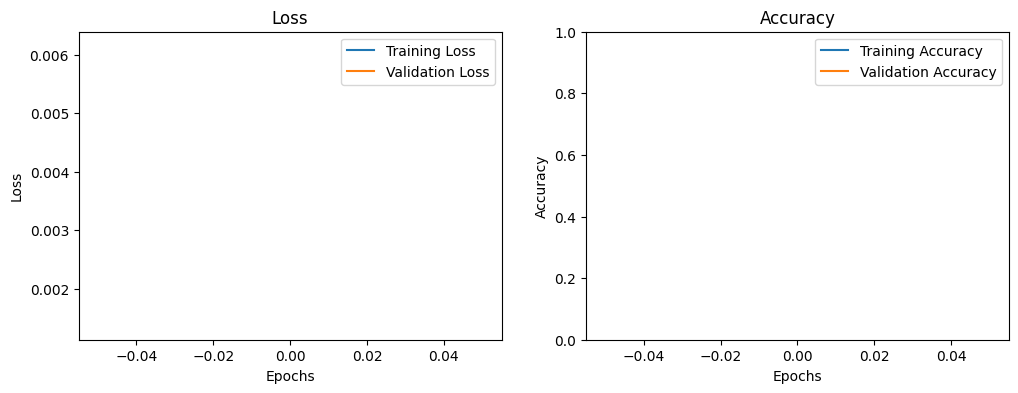

In [ ]:
history_df = pd.DataFrame(history.history)
plot_learning_curves(history_df)

In [ ]:
# prompt: 드라이브에 저장된 모델 불러오기
model_load_path = os.path.join('/content/drive/My Drive/models', 'model_mobilenetv2_basic.keras')
loaded_model = tf.keras.models.load_model(model_load_path)

# 불러온 모델 확인
loaded_model.summary()

# 불러온 모델 평가
loss, accuracy = loaded_model.evaluate(test_generator)
print(f"✅ Loaded model Test loss: {loss}")
print(f"✅ Loaded model Test accuracy: {accuracy}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,253,359 (12.41 MB)

 Trainable params: 331,791 (1.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 663,584 (2.53 MB)

94/94 ━━━━━━━━━━━━━━━━━━━━ 31s 306ms/step - accuracy: 0.9984 - loss: 0.0112
✅ Loaded model Test loss: 0.011214232072234154
✅ Loaded model Test accuracy: 0.9980000257492065


In [ ]:
# 데이터 예측
# Get the true classes (ground truth) from the test generator
true_classes = test_generator.classes

# Predict probabilities for each class using the model
predictions = loaded_model.predict(test_generator)

# Convert probabilities to predicted class indices (select the class with the highest probability)
predicted_classes = np.argmax(predictions, axis=1)

test_labels=test_generator.class_indices.keys()

94/94 ━━━━━━━━━━━━━━━━━━━━ 31s 318ms/step


In [ ]:
# Generate the classification report
# target_names assigns human-readable class names from the test generator
report = classification_report(true_classes, predicted_classes, target_names=test_labels)
print(report)

              precision    recall  f1-score   support

        Bean       1.00      1.00      1.00       200
Bitter_Gourd       1.00      0.99      1.00       200
Bottle_Gourd       1.00      0.99      1.00       200
     Brinjal       1.00      1.00      1.00       200
    Broccoli       1.00      1.00      1.00       200
     Cabbage       1.00      1.00      1.00       200
    Capsicum       1.00      1.00      1.00       200
      Carrot       1.00      1.00      1.00       200
 Cauliflower       0.99      1.00      1.00       200
    Cucumber       1.00      0.99      1.00       200
      Papaya       1.00      1.00      1.00       200
      Potato       1.00      1.00      1.00       200
     Pumpkin       1.00      0.99      1.00       200
      Radish       1.00      1.00      1.00       200
      Tomato       1.00      0.99      0.99       200

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00   

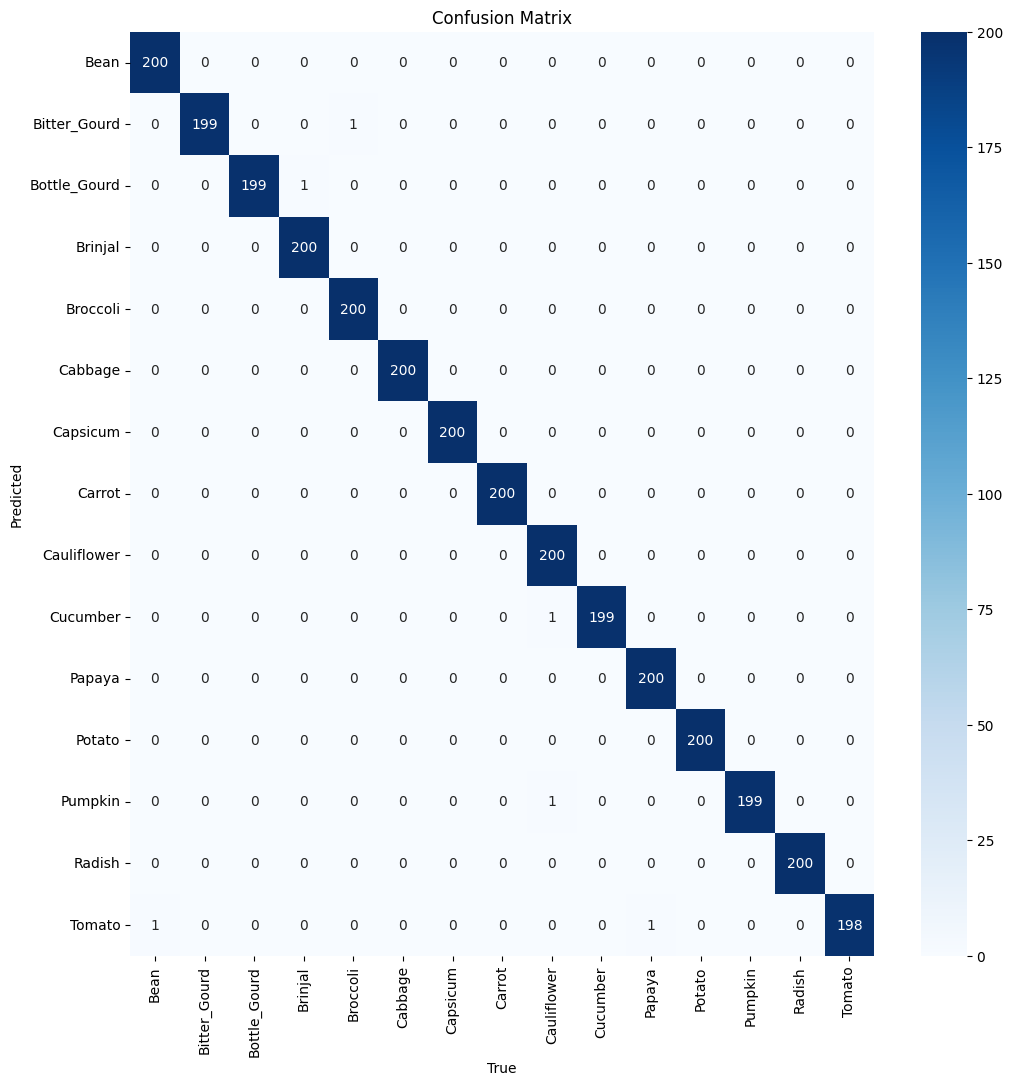

In [ ]:
plt.figure(figsize=(12,12))
cm=confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d',cmap="Blues", xticklabels=test_labels,yticklabels=test_labels)
plt.title("Confusion Matrix")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

### MobileNetV2 최적의 하이퍼파라미터 탐색

In [ ]:
# 학습 데이터 증강
train_datagen = ImageDataGenerator(
    rescale=1./255, # 픽셀 정규화
    rotation_range=20, # 1~20 무작위 회전
    width_shift_range=0.2, # 수평 방향 이동
    height_shift_range=0.2, # 수직 방향 이동
    shear_range=0.2, # 전단 변환
    zoom_range=0.2, # 확대, 축소
    horizontal_flip=0.2, # 뒤집기
    fill_mode='nearest', # 이미지 변형 중 빈 공간 채우기
)

# 테스트, 검증 데이터 정규화
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [ ]:
# 1. 모델 빌딩 함수
def build_model(hp):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    # Dense 레이어의 유닛 수 탐색: 128, 256, 512 중 선택
    dense_units = hp.Choice('dense_units', values=[128, 256, 512])

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(dense_units, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    # 학습률 하이퍼파라미터: 로그 스케일로 탐색
    lr = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 2. 배치 사이즈 튜닝을 위한 커스텀 Tuner 클래스 정의
class MyTuner(kt.tuners.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        # 배치 사이즈 하이퍼파라미터 추가: 16, 32, 64 중 선택
        hp = trial.hyperparameters
        batch_size = hp.Choice('batch_size', values=[16, 32, 64])
        kwargs['batch_size'] = batch_size
        return super(MyTuner, self).run_trial(trial, *args, **kwargs)

# 3. Tuner 생성
tuner = MyTuner(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # 탐색할 하이퍼파라미터 조합 수
    executions_per_trial=1,
    directory='my_dir',
    project_name='mobilenetv2_tuning'
)

# 4. 하이퍼파라미터 탐색 실행
tuner.search(train_generator, epochs=5, validation_data=val_generator)
tuner.results_summary()

# 5. 최적의 하이퍼파라미터 추출
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_lr = best_hps.get('learning_rate')
best_bs = best_hps.get('batch_size')
best_dense_units = best_hps.get('dense_units')

print("✅ Best learning rate:", best_lr)
print("✅ Best batch size:", best_bs)
print("✅ Best dense units:", best_dense_units)

Reloading Tuner from my_dir/mobilenetv2_tuning/tuner0.json
Results summary
Results in my_dir/mobilenetv2_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 4 summary
Hyperparameters:
dense_units: 128
learning_rate: 0.0009497969456542987
batch_size: 64
Score: 0.9980000257492065

Trial 1 summary
Hyperparameters:
dense_units: 128
learning_rate: 0.000976844384018483
batch_size: 64
Score: 0.9973333477973938

Trial 3 summary
Hyperparameters:
dense_units: 256
learning_rate: 9.052494618776521e-05
batch_size: 64
Score: 0.9950000047683716

Trial 0 summary
Hyperparameters:
dense_units: 512
learning_rate: 1.2419672348410803e-05
batch_size: 16
Score: 0.9786666631698608

Trial 2 summary
Hyperparameters:
dense_units: 256
learning_rate: 1.6723297752560498e-05
batch_size: 64
Score: 0.9776666760444641
✅ Best learning rate: 0.0009497969456542987
✅ Best batch size: 64
✅ Best dense units: 128


In [ ]:
# 6. 최적의 하이퍼파라미터로 모델 생성 및 최종 학습
model = build_model(best_hps)

# 최종 학습을 위한 콜백 정의 (필요에 따라 조정)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1)
checkpoint_path = os.path.join('/content/drive/My Drive/models', 'best_model_mobilenetv2.keras')
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1) # 가중치 저장

model.compile(optimizer=Adam(learning_rate=best_lr),
          loss='categorical_crossentropy',
          metrics=['accuracy'])

history = model.fit(train_generator, epochs=20, batch_size=best_bs,
                    validation_data=val_generator, callbacks=[early_stopping, reduce_lr, checkpoint])

model_save_path = os.path.join('/content/drive/My Drive/models', 'model_mobilenetv2_tuning.keras')
model.save(model_save_path)


Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4115 - loss: 1.9958
Epoch 1: val_accuracy improved from -inf to 0.97433, saving model to best_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 1023s 2s/step - accuracy: 0.4120 - loss: 1.9942 - val_accuracy: 0.9743 - val_loss: 0.2056 - learning_rate: 9.4980e-05
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8950 - loss: 0.4021
Epoch 2: val_accuracy improved from 0.97433 to 0.98300, saving model to best_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 1001s 2s/step - accuracy: 0.8950 - loss: 0.4020 - val_accuracy: 0.9830 - val_loss: 0.0889 - learning_rate: 9.4980e-05
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9388 - loss: 0.2359
Epoch 3: val_accuracy improved from 0.98300 to 0.98767, saving model to best_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 1000s 2s/step - accuracy: 0.9388 - loss: 0.2359 - val_accuracy: 0.9877 - val_loss: 0.0540 - learning_rate: 9.4980e-05
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f"✅ Test loss: {loss}")
print(f"✅ Test accuracy: {accuracy}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.9983 - loss: 0.0075
✅ Test loss: 0.009371351450681686
✅ Test accuracy: 0.9976666569709778


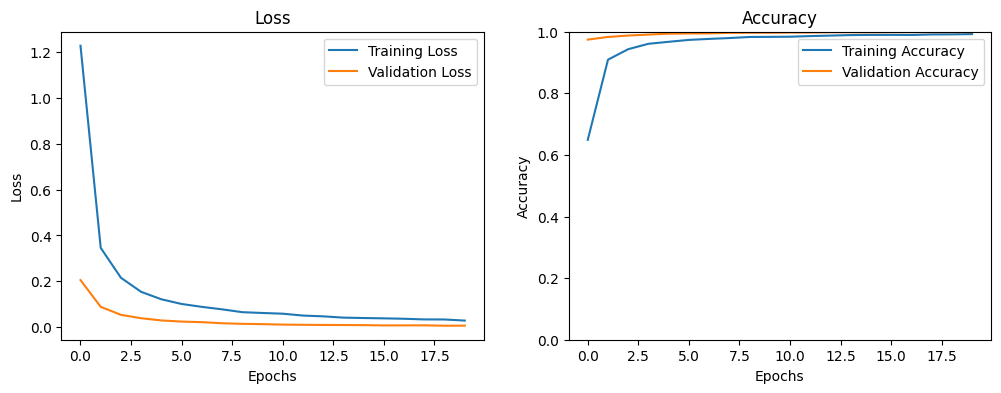

In [ ]:
history_df = pd.DataFrame(history.history)
plot_learning_curves(history_df)

In [ ]:
# 저장된 모델 로드
model_load_path = os.path.join('/content/drive/My Drive/models', 'model_mobilenetv2_tuning.keras')
loaded_model = tf.keras.models.load_model(model_load_path)

# 불러온 모델 확인
loaded_model.summary()

NameError: name 'os' is not defined

In [ ]:
# 불러온 모델 평가
loss, accuracy = loaded_model.evaluate(test_generator)
print(f"✅ Loaded model Test loss: {loss}")
print(f"✅ Loaded model Test accuracy: {accuracy}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.9973 - loss: 0.0095
✅ Loaded model Test loss: 0.009371349588036537
✅ Loaded model Test accuracy: 0.9976666569709778


In [ ]:
# 데이터 예측
# Get the true classes (ground truth) from the test generator
true_classes = test_generator.classes

# Predict probabilities for each class using the model
predictions = loaded_model.predict(test_generator)

# Convert probabilities to predicted class indices (select the class with the highest probability)
predicted_classes = np.argmax(predictions, axis=1)

test_labels=test_generator.class_indices.keys()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step


In [ ]:
# Generate the classification report
# target_names assigns human-readable class names from the test generator
report = classification_report(true_classes, predicted_classes, target_names=test_labels)
print(report)

              precision    recall  f1-score   support

        Bean       1.00      1.00      1.00       200
Bitter_Gourd       1.00      0.99      0.99       200
Bottle_Gourd       1.00      0.99      1.00       200
     Brinjal       0.99      1.00      1.00       200
    Broccoli       0.99      0.99      0.99       200
     Cabbage       1.00      1.00      1.00       200
    Capsicum       1.00      1.00      1.00       200
      Carrot       1.00      1.00      1.00       200
 Cauliflower       1.00      1.00      1.00       200
    Cucumber       0.99      0.99      0.99       200
      Papaya       1.00      1.00      1.00       200
      Potato       1.00      1.00      1.00       200
     Pumpkin       1.00      0.99      1.00       200
      Radish       1.00      1.00      1.00       200
      Tomato       1.00      0.99      1.00       200

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00   

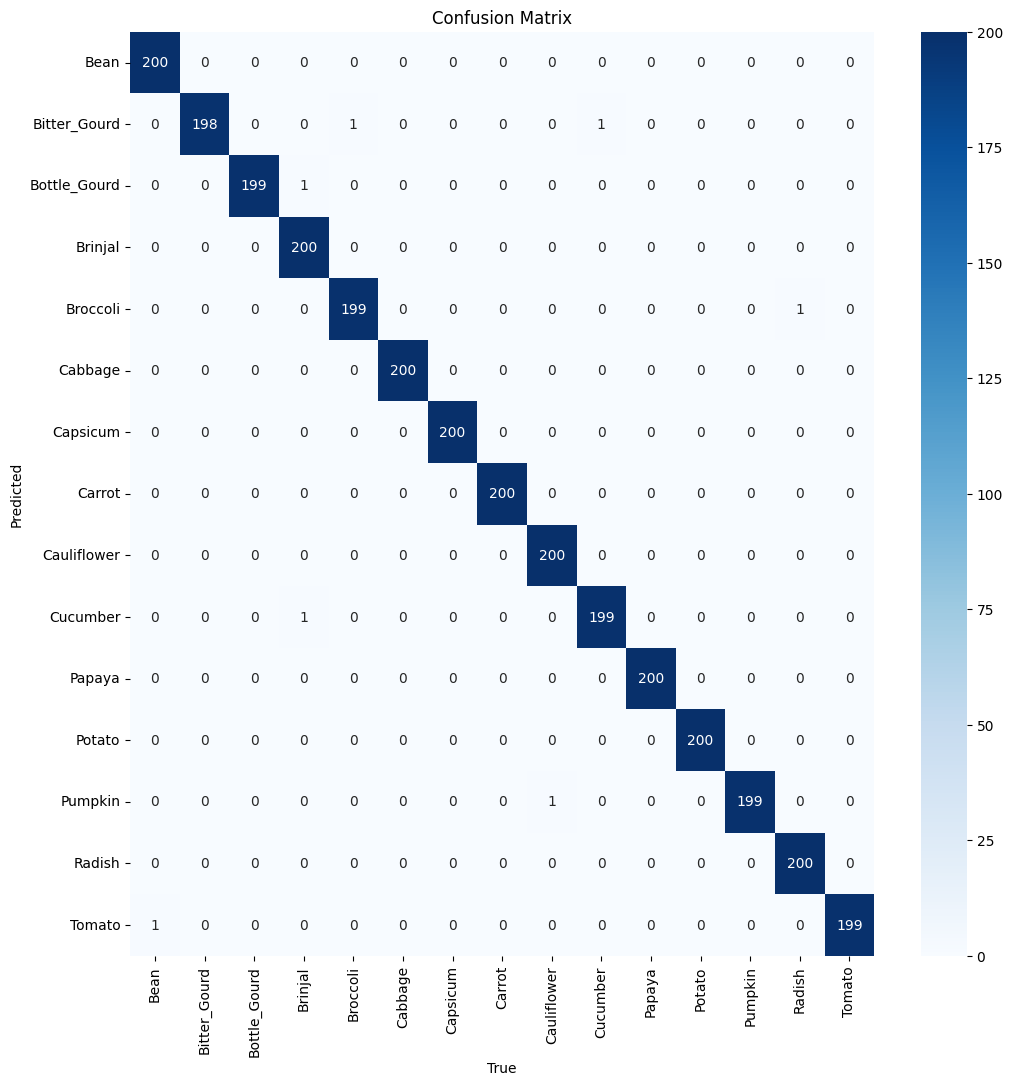

In [ ]:
plt.figure(figsize=(12,12))
cm=confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d',cmap="Blues", xticklabels=test_labels,yticklabels=test_labels)
plt.title("Confusion Matrix")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

### MobileNetV2 파인 튜닝

In [ ]:
# 저장된 모델 불러오기
model_load_path = os.path.join('/content/drive/My Drive/models', 'model_mobilenetv2_tuning.keras')
model = tf.keras.models.load_model(model_load_path)

# 불러온 모델 확인
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,755,695 (10.51 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 331,808 (1.27 MB)

In [ ]:
import pandas as pd
import datetime

best_lr = 0.0009497969456542987
best_bs = 64

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 모든 레이어를 학습 가능하도록 설정 (Fine-tuning)
for layer in base_model.layers:
  layer.trainable = True

# 최종 학습을 위한 콜백 정의 (필요에 따라 조정)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1)
checkpoint_path = os.path.join('/content/drive/My Drive/models', 'best_model_mobilenetv2.keras')
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1) # 가중치 저장

# 학습률을 줄여서 Fine-tuning 진행
model.compile(optimizer=Adam(learning_rate=best_lr / 10),  # 학습률을 1/10로 줄임
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 학습 로그를 저장할 파일 경로
log_file_path = '/content/drive/My Drive/training_log.csv'

# 학습 시작 시간 기록
start_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# 학습 로그를 저장할 리스트 초기화
log_data = []

# Fine-tuning 학습 진행
for epoch in range(20):
  print(f"Epoch {epoch+1}/20")
  history = model.fit(train_generator, epochs=1, batch_size=best_bs,
                      validation_data=val_generator, callbacks=[early_stopping, reduce_lr, checkpoint])

  # 현재 에포크의 손실 함수값과 정확도 가져오기
  loss = history.history['loss'][-1]
  accuracy = history.history['accuracy'][-1]
  val_loss = history.history['val_loss'][-1]
  val_accuracy = history.history['val_accuracy'][-1]

  # 로그 데이터 추가
  log_data.append([start_time, datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), epoch + 1, loss, accuracy, val_loss, val_accuracy])

# 학습 종료 시간 기록
end_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# 로그 데이터를 데이터프레임으로 변환
log_df = pd.DataFrame(log_data, columns=['Start Time', 'End Time', 'Epoch', 'Loss', 'Accuracy', 'Val_Loss', 'Val_Accuracy'])

# 로그 데이터를 CSV 파일로 저장
log_df.to_csv(log_file_path, index=False)

model_save_path = os.path.join('/content/drive/My Drive/models', 'model_mobilenetv2_full_fine_tuning.keras')
model.save(model_save_path)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 85/469 ━━━━━━━━━━━━━━━━━━━━ 12:10 2s/step - accuracy: 0.9917 - loss: 0.0333

KeyboardInterrupt: 

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f"✅ Test loss: {loss}")
print(f"✅ Test accuracy: {accuracy}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9980 - loss: 0.0049
✅ Test loss: 0.00459270877763629
✅ Test accuracy: 0.9983333349227905


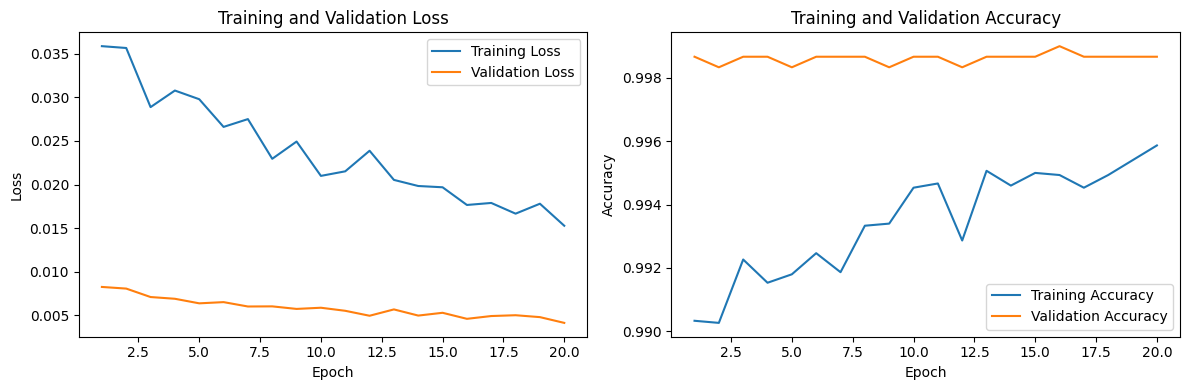

In [ ]:
# prompt: 위에 저장된 training_log 파일을 로드해서 학습 과정의 loss, accuracy 값을 그래프로 시각화해주는 코드를 작성해줘

import pandas as pd
import matplotlib.pyplot as plt

# 학습 로그 파일 경로
log_file_path = '/content/drive/My Drive/training_log.csv'

# 학습 로그 파일 로드
log_df = pd.read_csv(log_file_path)

# 에포크에 따른 손실 및 정확도 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(log_df['Epoch'], log_df['Loss'], label='Training Loss')
plt.plot(log_df['Epoch'], log_df['Val_Loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(log_df['Epoch'], log_df['Accuracy'], label='Training Accuracy')
plt.plot(log_df['Epoch'], log_df['Val_Accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# 저장된 모델 불러오기
model_load_path = os.path.join('/content/drive/My Drive/models', 'model_mobilenetv2_full_fine_tuning.keras')
loaded_model = tf.keras.models.load_model(model_load_path)

# 불러온 모델 확인
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,755,695 (10.51 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 331,808 (1.27 MB)

In [ ]:
loss, accuracy = loaded_model.evaluate(test_generator)
print(f"✅ Test loss: {loss}")
print(f"✅ Test accuracy: {accuracy}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9980 - loss: 0.0049
✅ Test loss: 0.00459270877763629
✅ Test accuracy: 0.9983333349227905


In [ ]:
# 데이터 예측
# Get the true classes (ground truth) from the test generator
true_classes = test_generator.classes

# Predict probabilities for each class using the model
predictions = loaded_model.predict(test_generator)

# Convert probabilities to predicted class indices (select the class with the highest probability)
predicted_classes = np.argmax(predictions, axis=1)

test_labels=test_generator.class_indices.keys()

94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step


In [ ]:
# Generate the classification report
# target_names assigns human-readable class names from the test generator
report = classification_report(true_classes, predicted_classes, target_names=test_labels)
print(report)

              precision    recall  f1-score   support

        Bean       1.00      1.00      1.00       200
Bitter_Gourd       1.00      0.99      0.99       200
Bottle_Gourd       1.00      1.00      1.00       200
     Brinjal       1.00      1.00      1.00       200
    Broccoli       1.00      0.99      1.00       200
     Cabbage       1.00      1.00      1.00       200
    Capsicum       1.00      1.00      1.00       200
      Carrot       1.00      1.00      1.00       200
 Cauliflower       1.00      1.00      1.00       200
    Cucumber       1.00      1.00      1.00       200
      Papaya       1.00      1.00      1.00       200
      Potato       1.00      1.00      1.00       200
     Pumpkin       1.00      0.99      1.00       200
      Radish       1.00      1.00      1.00       200
      Tomato       0.99      0.99      0.99       200

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00   

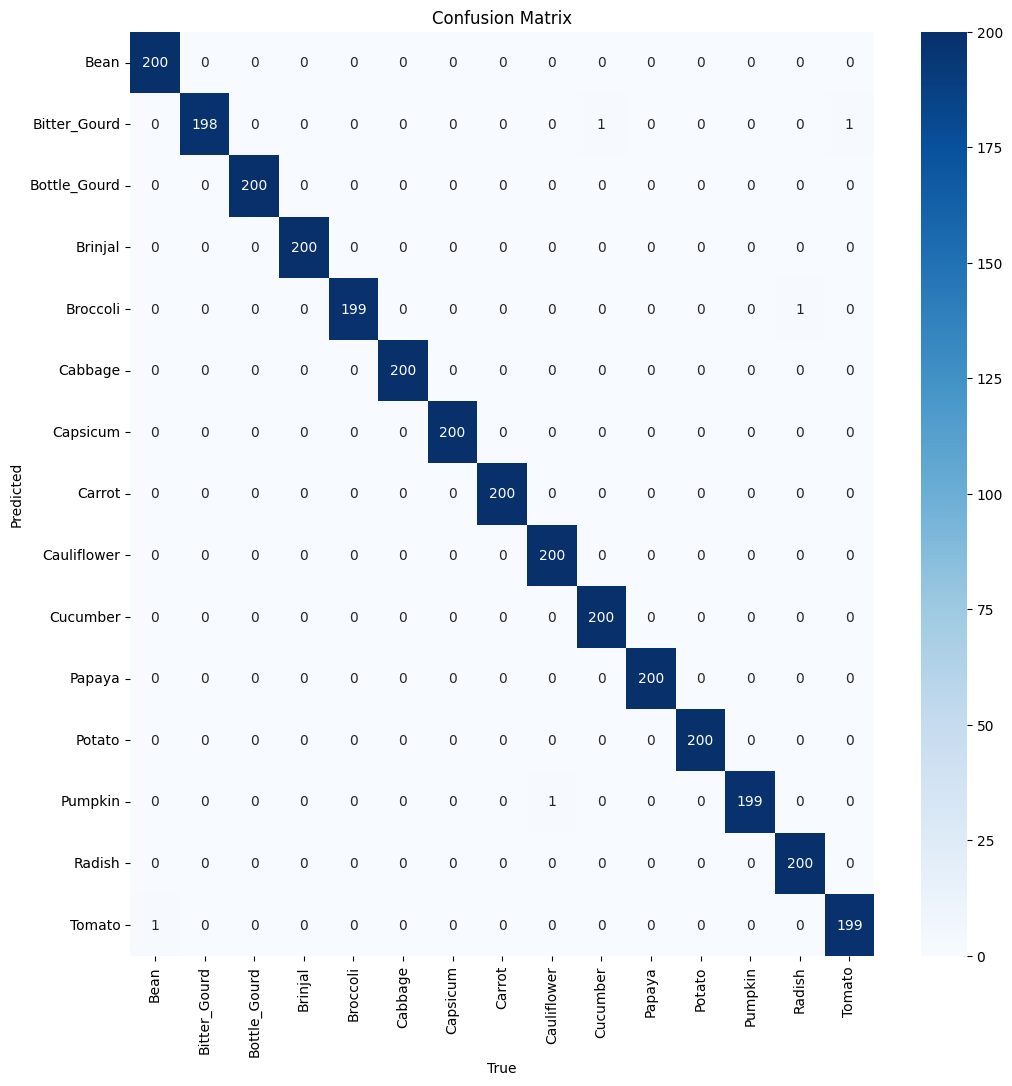

In [ ]:
plt.figure(figsize=(12,12))
cm=confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d',cmap="Blues", xticklabels=test_labels,yticklabels=test_labels)
plt.title("Confusion Matrix")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [ ]:
!pip install pymysql

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 2.8 MB/s eta 0:00:00


In [ ]:
import pymysql
import csv

# Google Drive에 저장된 CSV 로그 파일 경로
log_file_path = '/content/drive/MyDrive/mobilenetv2_fulltunning_training_log.csv'

# MySQL 연결 정보 (각자 환경에 맞게 수정)
mysql_config = {
    'host': 'hohst',
    'port': 21739,
    'user': 'user',
    'password': 'password',
    'db': 'defaultdb',
    'charset': 'utf8mb4'
}

# 테이블 생성 쿼리 (이미 존재하면 건너뜁니다.)
create_table_sql = """
CREATE TABLE IF NOT EXISTS mobilenetv2_finetunning_log (
    id INT AUTO_INCREMENT PRIMARY KEY,
    start_time DATETIME,
    end_time DATETIME,
    epoch INT,
    loss FLOAT,
    accuracy FLOAT,
    val_loss FLOAT,
    val_accuracy FLOAT
);
"""

# CSV 파일에서 읽어온 문자열 데이터를 데이터 타입에 맞게 변환하는 함수 예시
def parse_row(row):
    # row: [start_time, end_time, epoch, loss, accuracy, val_loss, val_accuracy]
    # 필요에 따라 날짜 포맷이나 실수 변환을 추가로 적용할 수 있습니다.
    start_time = row[0]
    end_time = row[1]
    epoch = int(row[2])
    loss = float(row[3])
    accuracy = float(row[4])
    val_loss = float(row[5])
    val_accuracy = float(row[6])
    return (start_time, end_time, epoch, loss, accuracy, val_loss, val_accuracy)

try:
    # MySQL 데이터베이스 연결
    conn = pymysql.connect(**mysql_config)

    with conn.cursor() as cursor:
        # 테이블 생성
        cursor.execute(create_table_sql)
        print("테이블 생성 완료 또는 이미 존재합니다.")

        # CSV 파일 열기
        with open(log_file_path, 'r', newline='') as csvfile:
            csv_reader = csv.reader(csvfile)
            header = next(csv_reader)  # 헤더 행 건너뛰기

            # 데이터 삽입 쿼리
            insert_sql = """
                INSERT INTO mobilenetv2_finetunning_log
                (start_time, end_time, epoch, loss, accuracy, val_loss, val_accuracy)
                VALUES (%s, %s, %s, %s, %s, %s, %s)
            """

            for row in csv_reader:
                data = parse_row(row)
                cursor.execute(insert_sql, data)

    # 모든 변경 사항 커밋
    conn.commit()
    print("CSV 로그 데이터가 성공적으로 데이터베이스에 삽입되었습니다.")

except pymysql.Error as e:
    print(f"MySQL 에러: {e}")

except Exception as e:
    print(f"일반 에러: {e}")

finally:
    # 연결 종료
    if conn:
        conn.close()


테이블 생성 완료 또는 이미 존재합니다.
CSV 로그 데이터가 성공적으로 데이터베이스에 삽입되었습니다.


# VGG16 vs MobileNetV2

In [ ]:
import pandas as pd
import pymysql
import tensorflow as tf

# MySQL 연결 정보 (각자 환경에 맞게 수정)
db_config = {
    'host': 'host',
    'port': 21739,
    'user': 'user',
    'password': 'password',
    'db': 'defaultdb',
    'charset': 'utf8mb4'
}

# MySQL 연결 객체 생성
try:
    connection = pymysql.connect(**db_config)
except pymysql.Error as e:
    print(f"DB 연결 실패: {e}")
    raise

# 로그 파일 1 불러오기 및 총 학습시간 계산 (첫 번째 에포크 시작과 마지막 에포크 종료)
try:
    with connection.cursor() as cursor:
        cursor.execute("SELECT * FROM VGG16_fullfinetunning_training_new_log")
        log_data_1 = cursor.fetchall()

    # 실제 테이블에 맞게 컬럼명을 지정합니다.
    df_log_1 = pd.DataFrame(
        log_data_1,
        columns=['id', 'start_time', 'end_time', 'epoch', 'loss', 'accuracy', 'val_loss', 'val_accuracy']
    )
    df_log_1['start_time'] = pd.to_datetime(df_log_1['start_time'])
    df_log_1['end_time'] = pd.to_datetime(df_log_1['end_time'])

    # 첫 번째 에포크의 시작 시간과 마지막 에포크의 종료 시간 구하기
    first_epoch_index = df_log_1['epoch'].idxmin()
    last_epoch_index  = df_log_1['epoch'].idxmax()

    first_start_time = df_log_1.loc[first_epoch_index, 'start_time']
    last_end_time = df_log_1.loc[last_epoch_index, 'end_time']

    total_time_1 = (last_end_time - first_start_time).total_seconds()

except Exception as e:
    print(f"Error processing log file 1: {e}")
    total_time_1 = None

# 로그 파일 2 불러오기 및 총 학습시간 계산 (첫 번째 에포크 시작과 마지막 에포크 종료)
try:
    with connection.cursor() as cursor:
        cursor.execute("SELECT * FROM mobilenetv2_finetunning_log")
        log_data_2 = cursor.fetchall()

    df_log_2 = pd.DataFrame(
        log_data_2,
        columns=['id', 'start_time', 'end_time', 'epoch', 'loss', 'accuracy', 'val_loss', 'val_accuracy']
    )
    df_log_2['start_time'] = pd.to_datetime(df_log_2['start_time'])
    df_log_2['end_time'] = pd.to_datetime(df_log_2['end_time'])

    first_epoch_index = df_log_2['epoch'].idxmin()
    last_epoch_index  = df_log_2['epoch'].idxmax()

    first_start_time = df_log_2.loc[first_epoch_index, 'start_time']
    last_end_time = df_log_2.loc[last_epoch_index, 'end_time']

    total_time_2 = (last_end_time - first_start_time).total_seconds()

except Exception as e:
    print(f"Error processing log file 2: {e}")
    total_time_2 = None

# 모델 파일 경로 (Google Drive)
model_file_1_path = '/content/drive/MyDrive/models/model_VGG16_full_fine_tuning.keras'
model_file_2_path = '/content/drive/MyDrive/models/model_mobilenetv2_full_fine_tuning.keras'

# 모델 로드
try:
    model_1 = tf.keras.models.load_model(model_file_1_path)
    model_2 = tf.keras.models.load_model(model_file_2_path)
except Exception as e:
    print(f"모델 로드 에러: {e}")
    raise

# 모델 평가
try:
    loss1, accuracy1 = model_1.evaluate(test_generator)
    loss2, accuracy2 = model_2.evaluate(test_generator)
except Exception as e:
    print(f"모델 평가 에러: {e}")
    loss1, accuracy1, loss2, accuracy2 = None, None, None, None

# 평가 결과를 딕셔너리 형태로 저장
evaluation_result_1 = {'accuracy1': accuracy1, 'loss1': loss1}
evaluation_result_2 = {'accuracy2': accuracy2, 'loss2': loss2}

# 결과를 비교하는 DataFrame 생성
df_comparison = pd.DataFrame({
    'Model': ['VGG16 Model', 'MobileNetV2 Model'],
    'Total_Time (s)': [total_time_1, total_time_2],
    'Accuracy': [evaluation_result_1['accuracy1'], evaluation_result_2['accuracy2']],
    'Loss': [evaluation_result_1['loss1'], evaluation_result_2['loss2']]
})

print(df_comparison)

# MySQL 연결 종료
connection.close()


94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 165ms/step - accuracy: 0.9879 - loss: 0.0453
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.9980 - loss: 0.0049
               Model  Total_Time (s)  Accuracy      Loss
0        VGG16 Model          4725.0  0.981333  0.060834
1  MobileNetV2 Model          4562.0  0.998333  0.004593


In [ ]:
df_comparison

,Model,Total_Time (s),Accuracy,Loss
0,VGG16 Model,4725.0,0.981333,0.060834
1,MobileNetV2 Model,4562.0,0.998333,0.004593


In [ ]:
df_log_1['total_time_1']

,total_time_1
0,261.0
1,487.0
2,719.0
3,949.0
4,1211.0
5,1432.0
6,1656.0
7,1880.0
8,2102.0
9,2364.0
